# Example: Regression with `QNNRegressor`

In this example we show how to train the `QNNRegressor` to fit a logarithm. We will also use this demonstrator to show what happens if a QNN, that was trained on a noiseless simulator is executed on a noisy simulator.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevPQC
from squlearn.observables import IsingHamiltonian, SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP, Adam, SPSA

We will use Qiskit's `StatevectorSimulator` for trainning.

In [2]:
executor = Executor("statevector_simulator")

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC)

c:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\.venv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


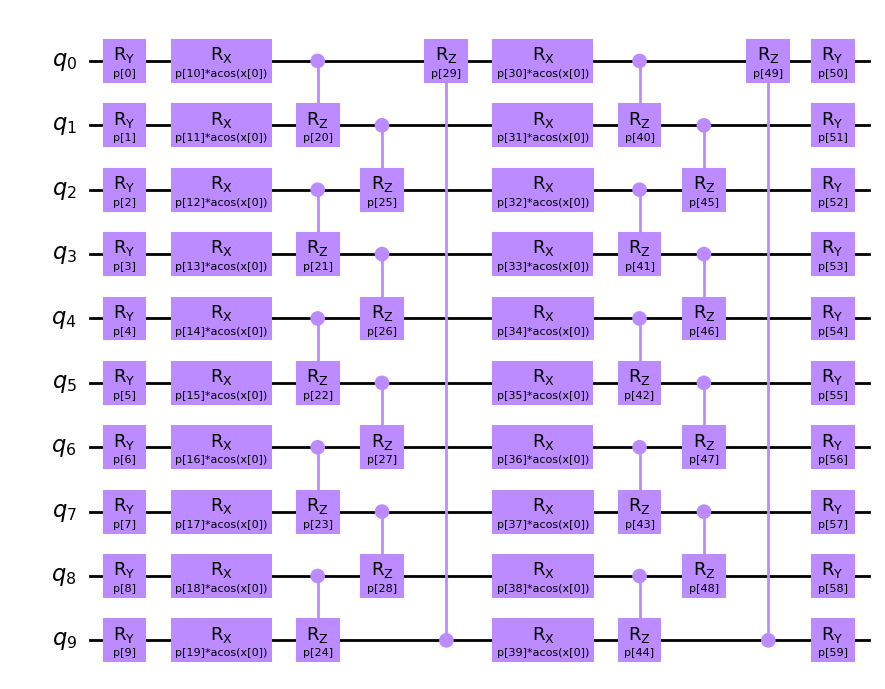

In [3]:
nqubits = 10
number_of_layers = 3

pqc = ChebyshevPQC(nqubits, 1, num_layers=number_of_layers)
pqc.draw("mpl")

We also need an observable

In [4]:
ising_op = SummedPaulis(nqubits)#, I="S", Z="S", ZZ="S")
print(ising_op)

SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4]), ParameterExpression(1.0*p[5]),
 ParameterExpression(1.0*p[6]), ParameterExpression(1.0*p[7]),
 ParameterExpression(1.0*p[8]), ParameterExpression(1.0*p[9]),
 ParameterExpression(1.0*p[10])])


Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `SquaredLoss` and `SLSQP` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator.

In [5]:
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(pqc, ising_op, executor, SquaredLoss(), SLSQP(), param_ini, param_op_ini,variance=0.005)

self._pennylane_gates [<class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RX'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RX'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RX'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RX'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RX'>, <class 'pennylane.ops.qubit.parametric_ops_sing

## Training

Now we are ready to train the model to fit the logarithm funciton

In [6]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

reg.fit(x_space, ref_values)

fit: 100%|██████████| 100/100 [00:59<00:00,  1.78it/s]

## Evaluation

Let's check the trained parameters of the PQC and operator

In [7]:
print("Result PQC params:", reg.param)
print("Result operator params:", reg.param_op)

Result PQC params: [-0.99990414  0.20306111  0.30392166 -0.13238214  0.83050933 -0.04349143
  3.16748499  2.44467148  0.31512941  0.95625695  0.30325425  0.41695463
  0.53363274  1.27979085 -0.5740203  -1.45145145 -0.29814578 -0.28417216
 -0.24663187  1.16900017 -0.61709439 -1.31612807  0.38388094  0.35976537
  0.03961388  0.4883154  -0.32538044 -0.08755128  0.3849762   0.62844661
 -0.13157765  0.86249183  0.06858601  0.05763911 -0.44256168 -0.73422564
  0.99211324  0.27152322  0.24573427 -0.03892566  2.14849215  1.06278587
  1.47674858 -0.81815658  0.38938469  0.93258308  0.73158002  1.49521128
  1.00340513  0.00430258  1.11803533  0.28995042  1.85148451 -0.3355831
  1.41764745  0.57695958  2.21916639  1.29675443 -0.80771266  0.97578923]
Result operator params: [-1.85200751  1.95438633  1.79848548  1.62471886  2.7671014   2.56602603
 -0.50179548  2.65136583 -0.11124508 -2.16273826  1.09736803]


Also let's plot the predicted function vs. the actual logarithm function

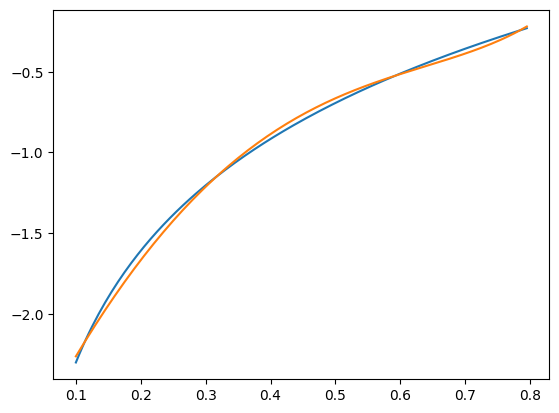

In [8]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

Let's also plot the error of the QNN.

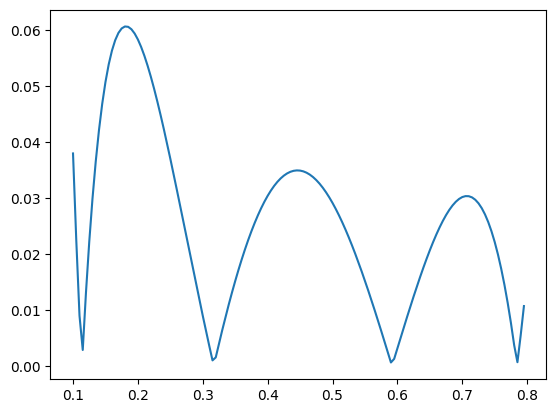

In [9]:
plt.plot(x, np.abs(y - np.log(x)))

## Evaluation on noisy simulator

Finally let's evaluate the trained `QNNRegressor` on Qiskit's `QasmSimulator`.

self._pennylane_gates [<class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RY'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RX'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RX'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RX'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RX'>, <class 'pennylane.ops.qubit.parametric_ops_single_qubit.RX'>, <class 'pennylane.ops.qubit.parametric_ops_sing

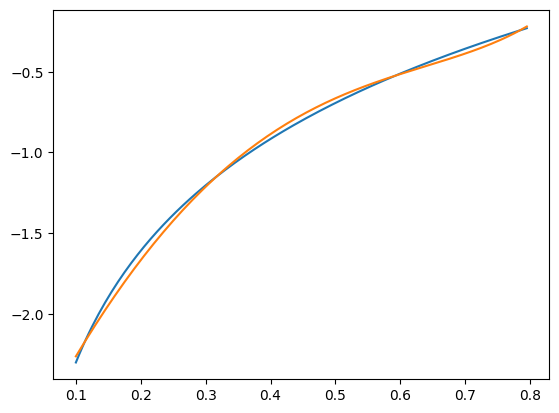

In [10]:
qasm = Executor("qasm_simulator")
qnn_qasm = QNNRegressor(pqc, ising_op, qasm, SquaredLoss, SLSQP(), reg.param, reg.param_op)
qnn_qasm._is_fitted = True
y = qnn_qasm.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

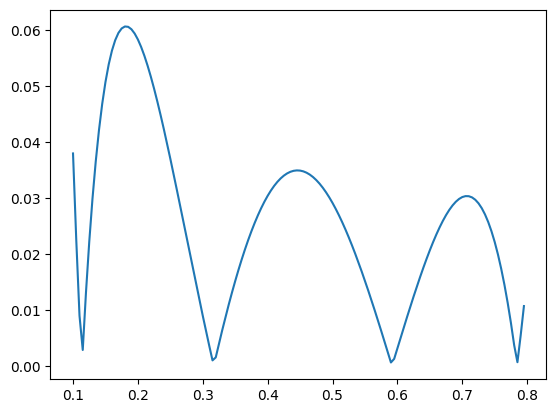

In [11]:
plt.plot(x, np.abs(y - np.log(x)))

We see, that the model is now subject to noise.